In this project, I will be creating a predictive model based on MLB pitches. The data I will be providing comes from <a href="https://www.kaggle.com/pschale/mlb-pitch-data-20152018#pitches.csv">Kaggle</a>, and covers MLB pitches recorded between 2015 and 2018 along with other related data. The model will use variables to make a binary prediction whether the pitch about to be thrown will be a fastball or not. I also test several different models to see which produces the highest scoring results. This notebook is replicated from a previous capstone project, but is instead done with Dask Dataframes and Arrays instead of Pandas and Numpy.

In [1]:
!pip install --upgrade "dask[complete]"

Requirement already up-to-date: dask[complete] in c:\users\brian\anaconda3\lib\site-packages (2.11.0)


<center><h2>
    Exploratory Data Analysis
    </h2></center>

In [2]:
# Imports here
%matplotlib inline

import matplotlib.pyplot as plt
import dask.array as da
import dask.dataframe as dd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import seaborn as sns
from sklearn.svm import SVC
sns.set()
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import boxcox
from sklearn.preprocessing import QuantileTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_recall_curve, roc_auc_score, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [3]:
pitches_df = dd.read_csv(r'C:\Users\Brian\Desktop\pitches.csv')

In [4]:
atbat_df = dd.read_csv (r'C:\Users\Brian\Desktop\atbats.csv')

In [5]:
pitches_df.compute()

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,...,event_num,b_score,ab_id,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,0.416000,2.963000,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665000,...,3,0.0,2.015000e+09,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.191000,2.347000,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043000,...,4,0.0,2.015000e+09,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2,-0.518000,3.284000,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368000,...,5,0.0,2.015000e+09,0.0,2.0,0.0,3.0,0.0,0.0,0.0
3,-0.641000,1.221000,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104000,...,6,0.0,2.015000e+09,0.0,2.0,0.0,4.0,0.0,0.0,0.0
4,-1.821000,2.083000,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280000,...,7,0.0,2.015000e+09,1.0,2.0,0.0,5.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4026,0.230280,1.784910,83.9,78.2,608.594,275.800,10.5,8.8,23.9,-5.097492,...,568,1.0,2.018186e+09,3.0,2.0,2.0,9.0,0.0,0.0,0.0
4027,-1.211049,2.479020,97.7,89.5,2262.907,155.009,-26.9,2.9,23.8,9.344343,...,572,1.0,2.018186e+09,0.0,0.0,2.0,1.0,1.0,0.0,0.0
4028,-0.444578,2.619287,97.3,89.6,2514.010,147.166,-40.5,3.3,23.8,13.292081,...,577,1.0,2.018186e+09,1.0,0.0,2.0,2.0,0.0,1.0,0.0
4029,-0.259813,1.336484,95.9,88.6,2318.775,144.921,-34.2,3.8,23.8,12.786338,...,578,1.0,2.018186e+09,1.0,1.0,2.0,3.0,0.0,1.0,0.0


In [6]:
pitches_df.columns

Index(['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir',
       'break_angle', 'break_length', 'break_y', 'ax', 'ay', 'az', 'sz_bot',
       'sz_top', 'type_confidence', 'vx0', 'vy0', 'vz0', 'x', 'x0', 'y', 'y0',
       'z0', 'pfx_x', 'pfx_z', 'nasty', 'zone', 'code', 'type', 'pitch_type',
       'event_num', 'b_score', 'ab_id', 'b_count', 's_count', 'outs',
       'pitch_num', 'on_1b', 'on_2b', 'on_3b'],
      dtype='object')

In [7]:
atbat_df.compute()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,True
1,2015000002,518792,Double,201500001,1,1,0,L,452657,L,True
2,2015000003,407812,Single,201500001,1,1,0,L,452657,R,True
3,2015000004,425509,Strikeout,201500001,1,2,0,L,452657,R,True
4,2015000005,571431,Strikeout,201500001,1,3,0,L,452657,L,True
...,...,...,...,...,...,...,...,...,...,...,...
740384,2018185570,543768,Groundout,201802431,9,3,1,L,448802,L,True
740385,2018185571,502517,Strikeout,201802431,9,1,3,L,623352,L,False
740386,2018185572,450314,Flyout,201802431,9,2,3,L,623352,R,False
740387,2018185573,595879,Single,201802431,9,2,3,L,623352,R,False


In [8]:
df_joined = dd.merge(left=pitches_df, right=atbat_df).compute()

In [9]:
df_joined

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,...,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top
0,0.416000,2.963000,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665000,...,572761,Groundout,201500001,1,1,0,L,452657,L,True
1,-0.191000,2.347000,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043000,...,572761,Groundout,201500001,1,1,0,L,452657,L,True
2,-0.518000,3.284000,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368000,...,572761,Groundout,201500001,1,1,0,L,452657,L,True
3,-0.641000,1.221000,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104000,...,572761,Groundout,201500001,1,1,0,L,452657,L,True
4,-1.821000,2.083000,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280000,...,572761,Groundout,201500001,1,1,0,L,452657,L,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4026,0.230280,1.784910,83.9,78.2,608.594,275.800,10.5,8.8,23.9,-5.097492,...,595879,Single,201802431,9,2,3,L,623352,R,False
4027,-1.211049,2.479020,97.7,89.5,2262.907,155.009,-26.9,2.9,23.8,9.344343,...,519203,Flyout,201802431,9,3,3,L,623352,L,False
4028,-0.444578,2.619287,97.3,89.6,2514.010,147.166,-40.5,3.3,23.8,13.292081,...,519203,Flyout,201802431,9,3,3,L,623352,L,False
4029,-0.259813,1.336484,95.9,88.6,2318.775,144.921,-34.2,3.8,23.8,12.786338,...,519203,Flyout,201802431,9,3,3,L,623352,L,False


In [10]:
df_joined.columns

Index(['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir',
       'break_angle', 'break_length', 'break_y', 'ax', 'ay', 'az', 'sz_bot',
       'sz_top', 'type_confidence', 'vx0', 'vy0', 'vz0', 'x', 'x0', 'y', 'y0',
       'z0', 'pfx_x', 'pfx_z', 'nasty', 'zone', 'code', 'type', 'pitch_type',
       'event_num', 'b_score', 'ab_id', 'b_count', 's_count', 'outs',
       'pitch_num', 'on_1b', 'on_2b', 'on_3b', 'batter_id', 'event', 'g_id',
       'inning', 'o', 'p_score', 'p_throws', 'pitcher_id', 'stand', 'top'],
      dtype='object')

In [11]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2867154 entries, 0 to 4030
Data columns (total 50 columns):
px                 float64
pz                 float64
start_speed        float64
end_speed          float64
spin_rate          float64
spin_dir           float64
break_angle        float64
break_length       float64
break_y            float64
ax                 float64
ay                 float64
az                 float64
sz_bot             float64
sz_top             float64
type_confidence    float64
vx0                float64
vy0                float64
vz0                float64
x                  float64
x0                 float64
y                  float64
y0                 float64
z0                 float64
pfx_x              float64
pfx_z              float64
nasty              float64
zone               float64
code               object
type               object
pitch_type         object
event_num          int64
b_score            float64
ab_id              float64
b_co

In [12]:
# I elect to drop all null values here.
df_joined = df_joined.dropna(axis=0)

In [13]:
df_joined

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,...,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top
0,0.416000,2.963000,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665000,...,572761,Groundout,201500001,1,1,0,L,452657,L,True
1,-0.191000,2.347000,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043000,...,572761,Groundout,201500001,1,1,0,L,452657,L,True
2,-0.518000,3.284000,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368000,...,572761,Groundout,201500001,1,1,0,L,452657,L,True
3,-0.641000,1.221000,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104000,...,572761,Groundout,201500001,1,1,0,L,452657,L,True
4,-1.821000,2.083000,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280000,...,572761,Groundout,201500001,1,1,0,L,452657,L,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4026,0.230280,1.784910,83.9,78.2,608.594,275.800,10.5,8.8,23.9,-5.097492,...,595879,Single,201802431,9,2,3,L,623352,R,False
4027,-1.211049,2.479020,97.7,89.5,2262.907,155.009,-26.9,2.9,23.8,9.344343,...,519203,Flyout,201802431,9,3,3,L,623352,L,False
4028,-0.444578,2.619287,97.3,89.6,2514.010,147.166,-40.5,3.3,23.8,13.292081,...,519203,Flyout,201802431,9,3,3,L,623352,L,False
4029,-0.259813,1.336484,95.9,88.6,2318.775,144.921,-34.2,3.8,23.8,12.786338,...,519203,Flyout,201802431,9,3,3,L,623352,L,False


In [14]:
# Creating dataframe I will be cleaning using only the columns needed for feature engineering
df = df_joined[['pitch_type','b_score', 'p_score', 'b_count', 's_count', 'pitch_num', 'outs', 'on_1b', 'on_2b', 'on_3b',
                'inning', 'p_throws', 'stand']]

In [15]:
df.isnull().sum()

pitch_type    0
b_score       0
p_score       0
b_count       0
s_count       0
pitch_num     0
outs          0
on_1b         0
on_2b         0
on_3b         0
inning        0
p_throws      0
stand         0
dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2847250 entries, 0 to 4030
Data columns (total 13 columns):
pitch_type    object
b_score       float64
p_score       int64
b_count       float64
s_count       float64
pitch_num     float64
outs          float64
on_1b         float64
on_2b         float64
on_3b         float64
inning        int64
p_throws      object
stand         object
dtypes: float64(8), int64(2), object(3)
memory usage: 304.1+ MB


In [17]:
df

,pitch_type,b_score,p_score,b_count,s_count,pitch_num,outs,on_1b,on_2b,on_3b,inning,p_throws,stand
0,FF,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,L,L
1,FF,0.0,0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1,L,L
2,FF,0.0,0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,1,L,L
3,FF,0.0,0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,1,L,L
4,CU,0.0,0,1.0,2.0,5.0,0.0,0.0,0.0,0.0,1,L,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4026,SL,1.0,3,3.0,2.0,9.0,2.0,0.0,0.0,0.0,9,L,R
4027,FF,1.0,3,0.0,0.0,1.0,2.0,1.0,0.0,0.0,9,L,L
4028,FF,1.0,3,1.0,0.0,2.0,2.0,0.0,1.0,0.0,9,L,L
4029,FF,1.0,3,1.0,1.0,3.0,2.0,0.0,1.0,0.0,9,L,L


In [18]:
# Defining my outcome variable fastball, the four pitch types listed are all different types of fastballs
df['fastball'] = df['pitch_type'].isin(['FF', 'FT', 'FC', 'FS'])

In [19]:
# Creating a feature that checks whether the previous row's pitch is a fastball. I verified the rows are related by ab_id
df['prev_pitch_fast'] = da.where(df['fastball'].shift(1) == True,1,0)
df.loc[df['pitch_num']==1.0,['prev_pitch_fast']] = 0

In [20]:
df.head(15)

,pitch_type,b_score,p_score,b_count,s_count,pitch_num,outs,on_1b,on_2b,on_3b,inning,p_throws,stand,fastball,prev_pitch_fast
0,FF,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,L,L,True,0
1,FF,0.0,0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1,L,L,True,1
2,FF,0.0,0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,1,L,L,True,1
3,FF,0.0,0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,1,L,L,True,1
4,CU,0.0,0,1.0,2.0,5.0,0.0,0.0,0.0,0.0,1,L,L,False,1
5,FF,0.0,0,2.0,2.0,6.0,0.0,0.0,0.0,0.0,1,L,L,True,0
6,FF,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1,L,L,True,0
7,FC,0.0,0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,1,L,L,True,1
8,FF,0.0,0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1,L,R,True,0
9,FF,0.0,0,1.0,0.0,2.0,1.0,0.0,1.0,0.0,1,L,R,True,1


In [21]:
# The next few rows are some feature engineering work in which I create new features
df['same_side'] = (df['p_throws'] == df['stand'])

In [22]:
df.drop(columns=['p_throws', 'stand', 'pitch_type'], inplace=True)

In [23]:
df['pitcher_losing'] = (df['p_score'] < df['b_score'])

In [24]:
df['RISP'] = (df['on_2b'] + df['on_3b'] > 0)

In [25]:
df.head(10)

,b_score,p_score,b_count,s_count,pitch_num,outs,on_1b,on_2b,on_3b,inning,fastball,prev_pitch_fast,same_side,pitcher_losing,RISP
0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,True,0,True,False,False
1,0.0,0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1,True,1,True,False,False
2,0.0,0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,1,True,1,True,False,False
3,0.0,0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,1,True,1,True,False,False
4,0.0,0,1.0,2.0,5.0,0.0,0.0,0.0,0.0,1,False,1,True,False,False
5,0.0,0,2.0,2.0,6.0,0.0,0.0,0.0,0.0,1,True,0,True,False,False
6,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1,True,0,True,False,False
7,0.0,0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,1,True,1,True,False,False
8,0.0,0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1,True,0,False,False,True
9,0.0,0,1.0,0.0,2.0,1.0,0.0,1.0,0.0,1,True,1,False,False,True


In [26]:
df['fastball'].value_counts()

True     1543070
False    1304180
Name: fastball, dtype: int64

In [27]:
# I used quantile transformation on some non-normal distributions as some columns have a lot of 0's,
# distributions are still bimodal but better than initial
quantile = QuantileTransformer(output_distribution='normal')
df['b_score'] = quantile.fit_transform(df[['b_score']])
df['p_score'] = quantile.fit_transform(df[['p_score']])
df['b_count'] = quantile.fit_transform(df[['b_count']])
df['pitch_num'] = quantile.fit_transform(df[['pitch_num']])

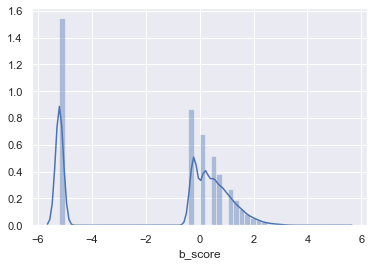

In [28]:
sns.distplot(df['b_score'])

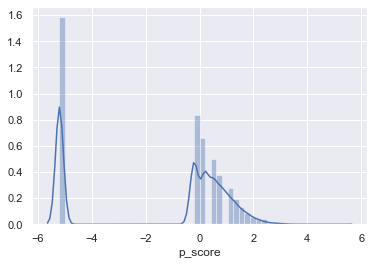

In [29]:
sns.distplot(df['p_score']) 

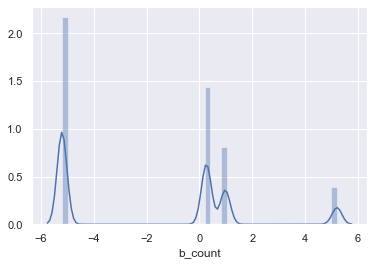

In [30]:
sns.distplot(df['b_count'])

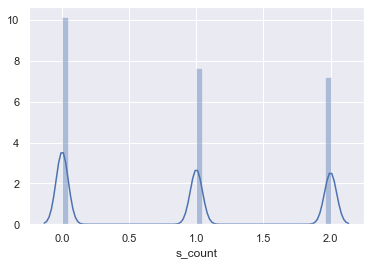

In [31]:
sns.distplot(df['s_count'])

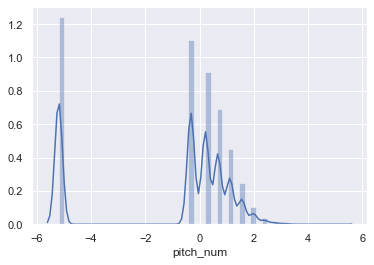

In [32]:
sns.distplot(df['pitch_num'])

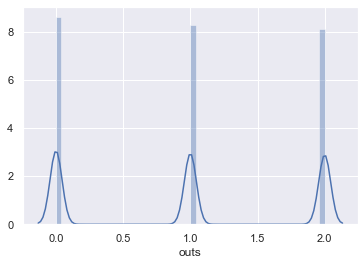

In [33]:
sns.distplot(df['outs'])

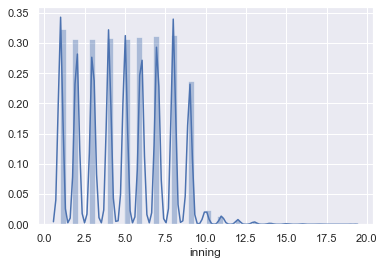

In [34]:
sns.distplot(df['inning'])

<center><h2>
    Model Evaluation
    </h2></center

Because this is a project that I had previously completed, I only include a GBC model since I know that this model performed better than the other models I tested.

In [35]:
# Fastball is my output variable. RISP, inning, and pitch_num had multicollinearity and dropping them improved model performance
y = df['fastball']
X = df.drop(columns=['fastball', 'RISP', 'inning', 'pitch_num'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)

In [36]:
y.value_counts()

True     1543070
False    1304180
Name: fastball, dtype: int64

In [37]:
# making room for cpu memory
del df_joined, pitches_df, atbat_df

<h2>
    Gradient Boosting Classifier
    </h2>

In [38]:
# parameters are tuned from gridsearchcv below
gbc = GradientBoostingClassifier(learning_rate=.06, max_depth=4, n_estimators=65)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.06, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=65,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [39]:
gbc.score(X_train, y_train), gbc.score(X_test, y_test)

(0.6029949951707788, 0.6019878830450435)

In [40]:
gbc_y_test_predict = gbc.predict(X_test)
gbc_y_train_predict = gbc.predict(X_train)

In [41]:
f1_score(y_train, gbc_y_train_predict, average='binary'), f1_score(y_test, gbc_y_test_predict, average='binary')

(0.6689687234603333, 0.6682795462861325)

In [42]:
print((classification_report(y_test, gbc_y_test_predict)))

              precision    recall  f1-score   support

       False       0.59      0.44      0.50    260716
        True       0.61      0.74      0.67    308734

    accuracy                           0.60    569450
   macro avg       0.60      0.59      0.59    569450
weighted avg       0.60      0.60      0.59    569450



In [43]:
print(classification_report(y_train, gbc_y_train_predict))

              precision    recall  f1-score   support

       False       0.59      0.44      0.50   1043464
        True       0.61      0.74      0.67   1234336

    accuracy                           0.60   2277800
   macro avg       0.60      0.59      0.59   2277800
weighted avg       0.60      0.60      0.59   2277800



In [44]:
gbc_params = {'learning_rate':[.06], 'max_depth':[4], 'n_estimators':[65]} 
gbc_grid = GridSearchCV(gbc, param_grid=gbc_params, cv=3, scoring='roc_auc', n_jobs=8)
gbc_grid.fit(X_train, y_train)
print(gbc_grid.best_params_) 
print(gbc_grid.best_score_)

{'learning_rate': 0.06, 'max_depth': 4, 'n_estimators': 65}
0.6351575499649335


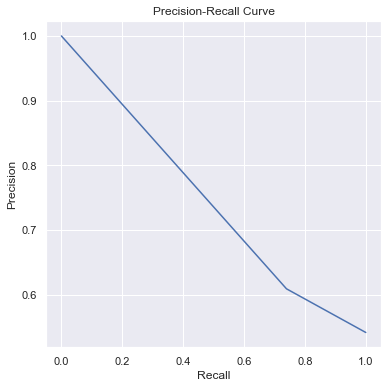

In [46]:
pres, rec, thresholds = precision_recall_curve(y_test, gbc_y_test_predict)
fig = plt.figure(figsize = (6, 6))
plt.plot(rec, pres)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [47]:
train_probs = gbc.predict_proba(X_train)[:,1]
test_probs = gbc.predict_proba(X_test)[:,1]

In [48]:
fpr, tpr, thresholds = roc_curve(y_test, test_probs)
print(fpr[1:30])
print(tpr[1:30])
print(thresholds[1:30])

[0.00000000e+00 0.00000000e+00 1.15067737e-05 1.15067737e-05
 1.15067737e-05 1.15067737e-05 2.30135473e-05 2.30135473e-05
 2.30135473e-05 2.68491385e-05 3.06847297e-05 3.45203210e-05
 3.83559122e-05 3.83559122e-05 4.21915034e-05 4.21915034e-05
 4.21915034e-05 4.21915034e-05 4.21915034e-05 4.21915034e-05
 4.98626858e-05 4.98626858e-05 4.98626858e-05 4.98626858e-05
 5.75338683e-05 6.13694595e-05 6.90406419e-05 6.90406419e-05
 6.90406419e-05]
[2.91513082e-05 1.84624952e-04 3.30381493e-04 4.11357350e-04
 4.24313487e-04 5.11767411e-04 6.89914295e-04 7.48216912e-04
 7.57934014e-04 8.09758562e-04 8.74539247e-04 9.26363795e-04
 1.08507647e-03 1.13042295e-03 1.26322336e-03 1.26970143e-03
 1.33448211e-03 1.34743825e-03 1.40574086e-03 1.45108734e-03
 1.49967286e-03 1.53206320e-03 1.55149741e-03 1.62275616e-03
 1.75231753e-03 1.80090304e-03 1.88187890e-03 1.91103021e-03
 1.94665958e-03]
[0.92974592 0.92834694 0.92794555 0.92707571 0.92685896 0.92676936
 0.92635984 0.92525126 0.92434989 0.92392794 

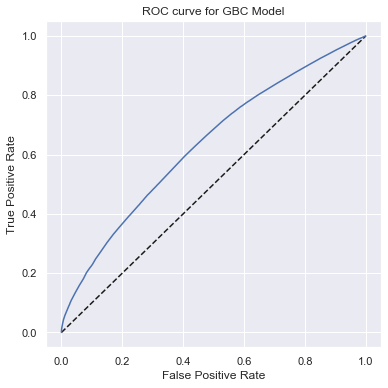

In [49]:
fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for GBC Model')
plt.show()

In [50]:
roc_auc_score(y_test, test_probs)

0.6335626781922237